# Support Vector Machine (SVM) : Practice & Experiments

**Authored by Alexandre Mathias DONNAT, Sr - Télécom Paris**

This notebooks contains : 

- Synthetic linear SVM (2 Gaussians): data generation with make_blobs, train/test split, Bayes risk (Monte Carlo), and visualization of the separating hyperplane + margins, with analysis of the effect of C and support vectors.

- Overlapping classes & model selection: soft-margin linear SVM with 5-fold cross-validation to select the optimal C*, then evaluation on a held-out test set.

- Overfitting demonstration with RBF SVM: grid exploration of (C, γ) showing the train/test gap when kernel complexity becomes too high.

- Non-linear classification pipeline: construction of a non-linearly separable dataset, comparison of linear vs RBF SVM, plus a learning curve (train/test vs training size) with the Bayes accuracy as a reference.

- Face recognition extension (LFW): impact of regularization (C), degradation under nuisance variables, improvement with PCA + RBF kernel, and a short theoretical bonus deriving the hinge-loss primal formulation and the “convex upper bound” interpretation.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')

## Example of using the SVC class from scikit-learn

In [ ]:
#  Data Generation
def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)

def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

Training score : 0.8
Testing score : 1.0


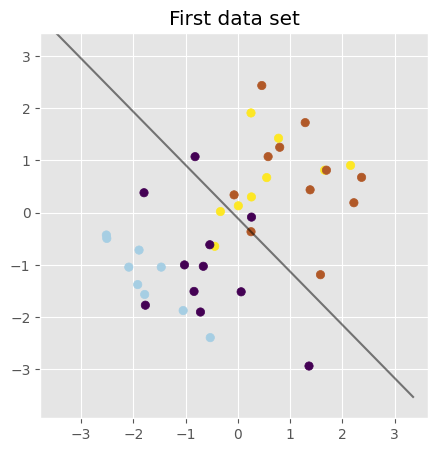

In [ ]:
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# compute and print the scores
score_train = clf.score(X_train, Y_train)
score_test = clf.score(X_test, Y_test)
print('Training score : %s' % score_train)
print('Testing score : %s' % score_test)

# display the points
plt.figure(1, figsize=(5, 5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    clf,
    X1,
    plot_method="contour",
    colors="k",
    levels=[0],
    alpha=0.5,
    ax=ax,
)
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train)
ax.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=plt.cm.Paired)
plt.title('First data set')
plt.axis('equal')
plt.show()

## Linear SVM

**1)** Draw a i.i.d. sample from a mixture of two Gaussian distributions : each class is a Gaussian with specific parameters. This time, use the function ```make_blobs``` available in ```sklearn.datasets``` library. Reserve 75% of the data for training and 25% for the test data.

<div class='alert alert-block alert-info'>
            Code:</div>

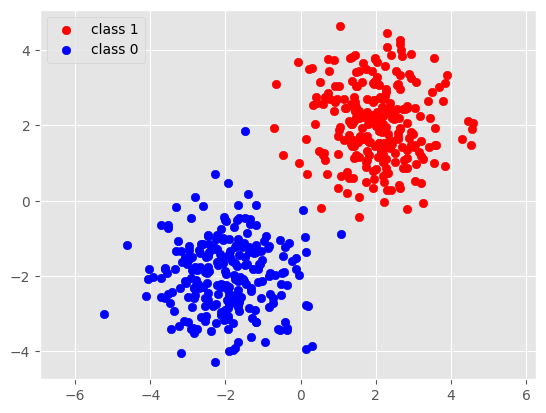

Shapes: (375, 2) (125, 2) (375,) (125,)


In [ ]:
# Create two centers for the two distributions
centers = np.array([[-2.0, -2.0],
                    [ 2.0,  2.0]])

# Use make_blobs to generate the two dimensions points from the two centers
X, y = make_blobs(
    n_samples=500,
    centers=centers,
    cluster_std=[1.0, 1.0],
    random_state=42
)

# Train / test split (75% / 25%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Plot the points (full dataset)
pos = np.where(y == 1)[0]
neg = np.where(y == 0)[0]
plt.scatter(X[pos,0], X[pos,1], c='r', label="class 1")
plt.scatter(X[neg,0], X[neg,1], c='b', label="class 0")
plt.axis('equal')
plt.legend()
plt.show()

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

**2)** Since the probability distributions are known, numerically estimate the Bayes risk. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
mu0 = np.array([-2.0, -2.0])
mu1 = np.array([ 2.0,  2.0])

Sigma0 = np.eye(2)
Sigma1 = np.eye(2)

n_mc = 200000  # adjustable
expectation = 0.0

for i in range(n_mc):
    rand = np.random.rand()  # in [0,1)
    if rand < 0.5:
        # First case: y = 0
        x = np.random.multivariate_normal(mu0, Sigma0)
    else:
        # Second case: y = 1
        x = np.random.multivariate_normal(mu1, Sigma1)

    # class-conditional densities
    p1 = multivariate_normal.pdf(x, mean=mu0, cov=Sigma0)  # p(x|y=0)
    p2 = multivariate_normal.pdf(x, mean=mu1, cov=Sigma1)  # p(x|y=1)

    # posterior probs with equal priors
    denom = p1 + p2
    post0 = p1 / denom
    post1 = p2 / denom

    # Bayes conditional risk (probability of error at x)
    risk_x = 1.0 - max(post0, post1)

    expectation += risk_x

expectation /= n_mc

print(f'Estimated Bayes risk: {np.around(expectation, 3)}')
print(f'Estimated Bayes accuracy: {1 - np.around(expectation, 3)}')

Estimated Bayes risk: 0.002
Estimated Bayes accuracy: 0.998


**3)** Draw the decision boundary $H$ induced by SVM as well as the hyperplanes $H_1$ and $H_{−1}$. Vary the parameter C to see its impact on the number of support vectors. We can use the code in the following example: https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<div class='alert alert-block alert-info'>
            Code:</div>

C=0.1    | #SV=14   | Train/Test scores: 0.995/1.000


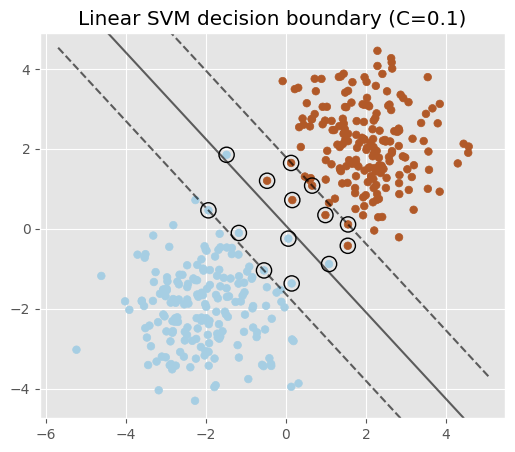

C=1      | #SV=7    | Train/Test scores: 0.997/0.992


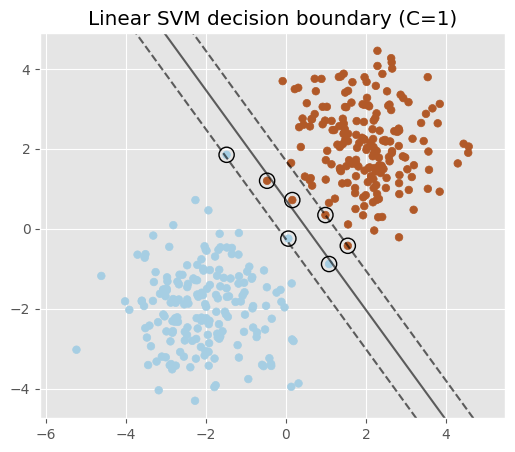

C=10     | #SV=4    | Train/Test scores: 1.000/0.992


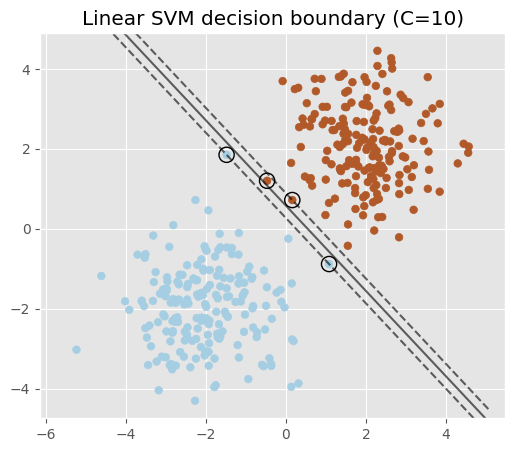

C=100    | #SV=3    | Train/Test scores: 1.000/0.992


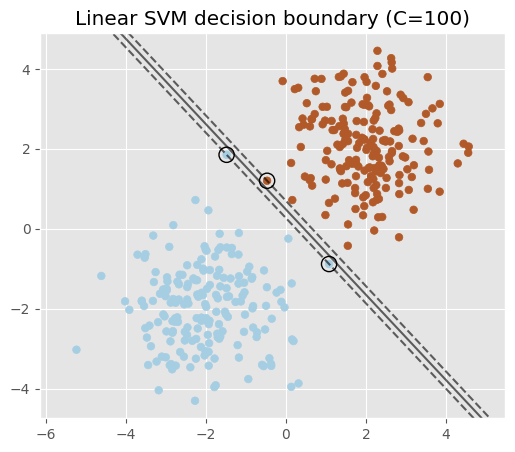

In [ ]:
Cs = [0.1, 1, 10, 100]

for C in Cs:
    # Create a linear SVM and train it on the training data
    clf = SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)

    print(f"C={C:<6} | #SV={clf.support_vectors_.shape[0]:<4} "
          f"| Train/Test scores: {clf.score(X_train, y_train):.3f}/{clf.score(X_test, y_test):.3f}")

    # Plot the data
    plt.figure(figsize=(6, 5))
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 300)
    yy = np.linspace(ylim[0], ylim[1], 300)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins: H (0), H1 (+1), H-1 (-1)
    ax.contour(
        XX, YY, Z,
        colors='k',
        levels=[-1, 0, 1],
        alpha=0.6,
        linestyles=['--', '-', '--']
    )

    # plot support vectors
    ax.scatter(
        clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
        s=120, linewidth=1, facecolors='none', edgecolors='k'
    )

    plt.title(f"Linear SVM decision boundary (C={C})")
    plt.axis('equal')
    plt.show()

**4)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation (for example, using the function ```GridSearchCV```) to find the optimal parameter $C∗$ to classify this new dataset using a linear kernel.

<div class='alert alert-block alert-info'>
            Code:</div>

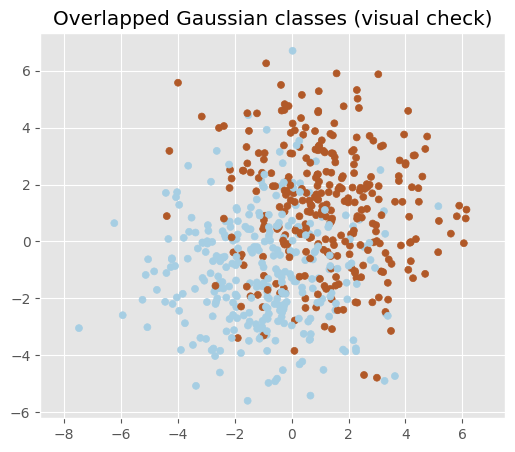

Best C* = 0.0031622776601683794
Best CV accuracy = 0.802
Train/Test accuracy = 0.802/0.753
Number of support vectors = 291


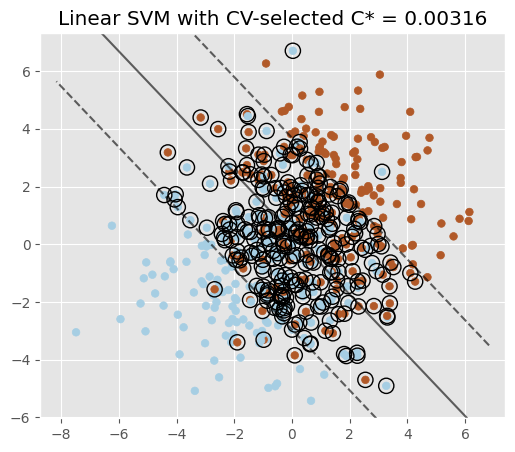

In [ ]:
# Generate overlapped Gaussians (new dataset)
centers_overlap = np.array([[-1.0, -1.0],
                            [ 1.0,  1.0]])

X2, y2 = make_blobs(
    n_samples=600,
    centers=centers_overlap,
    cluster_std=[2.0, 2.0],   
    random_state=42
)

# Quick visual check 
plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=y2, s=25, cmap=plt.cm.Paired)
plt.axis('equal')
plt.title("Overlapped Gaussian classes (visual check)")
plt.show()

# Train/test split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42, stratify=y2
)

# 5-fold Cross-Validation to find optimal C*
param_grid = {"C": np.logspace(-3, 3, 13)}  # 1e-3 ... 1e3
svc = SVC(kernel="linear")

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid.fit(X2_train, y2_train)

best_clf = grid.best_estimator_
print("Best C* =", grid.best_params_["C"])
print("Best CV accuracy =", np.round(grid.best_score_, 3))
print(f"Train/Test accuracy = {best_clf.score(X2_train, y2_train):.3f}/{best_clf.score(X2_test, y2_test):.3f}")
print("Number of support vectors =", best_clf.support_vectors_.shape[0])

# Plot decision boundary + margins + support vectors (best C*)
plt.figure(figsize=(6,5))
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train, s=30, cmap=plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = best_clf.decision_function(xy).reshape(XX.shape)

ax.contour(
    XX, YY, Z,
    colors='k',
    levels=[-1, 0, 1],
    alpha=0.6,
    linestyles=['--', '-', '--']
)

ax.scatter(
    best_clf.support_vectors_[:, 0], best_clf.support_vectors_[:, 1],
    s=120, linewidth=1, facecolors='none', edgecolors='k'
)

plt.title(f"Linear SVM with CV-selected C* = {grid.best_params_['C']:.3g}")
plt.axis("equal")
plt.show()

**5)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore $\gamma$ and $C$), can lead to overfitting.

<div class='alert alert-block alert-info'>
            Code:</div>

In [44]:
gammas = [0.1, 1, 10, 100]
Cs = [0.1, 1, 10, 100]

print("RBF SVM — train vs test (overfitting when gamma/C too large)")
print("-------------------------------------------------------------")
for gamma in gammas:
    for C in Cs:
        clf = SVC(kernel="rbf", gamma=gamma, C=C)
        clf.fit(X2_train, y2_train)

        train_acc = clf.score(X2_train, y2_train)
        test_acc  = clf.score(X2_test, y2_test)
        n_sv = clf.support_vectors_.shape[0]

        print(f"gamma={gamma:<5} C={C:<5} | #SV={n_sv:<4} | train={train_acc:.3f} test={test_acc:.3f} | gap={train_acc-test_acc:+.3f}")

RBF SVM — train vs test (overfitting when gamma/C too large)
-------------------------------------------------------------
gamma=0.1   C=0.1   | #SV=277  | train=0.807 test=0.767 | gap=+0.040
gamma=0.1   C=1     | #SV=221  | train=0.811 test=0.767 | gap=+0.044
gamma=0.1   C=10    | #SV=212  | train=0.809 test=0.767 | gap=+0.042
gamma=0.1   C=100   | #SV=207  | train=0.816 test=0.767 | gap=+0.049
gamma=1     C=0.1   | #SV=400  | train=0.811 test=0.773 | gap=+0.038
gamma=1     C=1     | #SV=277  | train=0.818 test=0.753 | gap=+0.064
gamma=1     C=10    | #SV=246  | train=0.840 test=0.733 | gap=+0.107
gamma=1     C=100   | #SV=226  | train=0.884 test=0.687 | gap=+0.198
gamma=10    C=0.1   | #SV=450  | train=0.880 test=0.700 | gap=+0.180
gamma=10    C=1     | #SV=398  | train=0.920 test=0.720 | gap=+0.200
gamma=10    C=10    | #SV=350  | train=0.969 test=0.713 | gap=+0.256
gamma=10    C=100   | #SV=328  | train=0.993 test=0.720 | gap=+0.273
gamma=100   C=0.1   | #SV=450  | train=0.996 test

## Non linear SVM

**6)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function ```make_blobs``` available in ```sklearn.datasetslibrary``` ).

<div class='alert alert-block alert-info'>
            Code:</div>

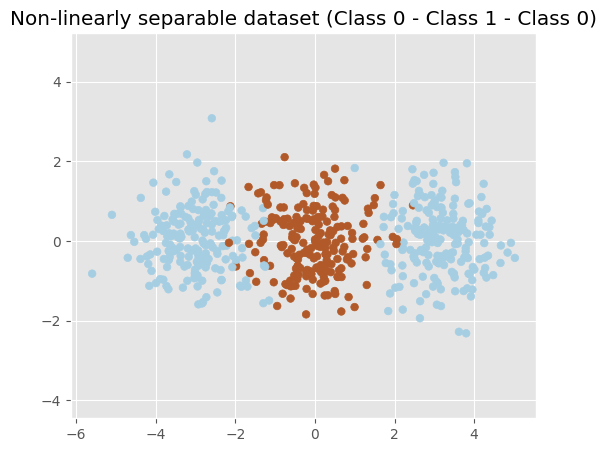

Shapes: (450, 2) (150, 2)


In [ ]:
# Generate a non-linearly separable dataset
# Class 0 - Class 1 - Class 0 (aligned centers)

centers = np.array([
    [-3.0, 0.0],   # Class 0
    [ 0.0, 0.0],   # Class 1
    [ 3.0, 0.0]    # Class 0
])

X, y_multi = make_blobs(
    n_samples=[200, 200, 200],
    centers=centers,
    cluster_std=[0.8, 0.8, 0.8],
    random_state=42
)

# Convert to binary labels:
y = np.zeros_like(y_multi)
y[y_multi == 1] = 1

# Visual check
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Paired, s=30)
plt.axis("equal")
plt.title("Non-linearly separable dataset (Class 0 - Class 1 - Class 0)")
plt.show()

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Shapes:", X_train.shape, X_test.shape)

**7)** Use an SVM with a linear kernel then a Gaussian (with well-adapted parameters, that you can obtain using, again, ```GridSearchCV```) then plot the decision boundaries of these algorithms on separate graphs.

<div class='alert alert-block alert-info'>
            Code:</div>

Linear SVM | Train/Test: 0.667/0.667


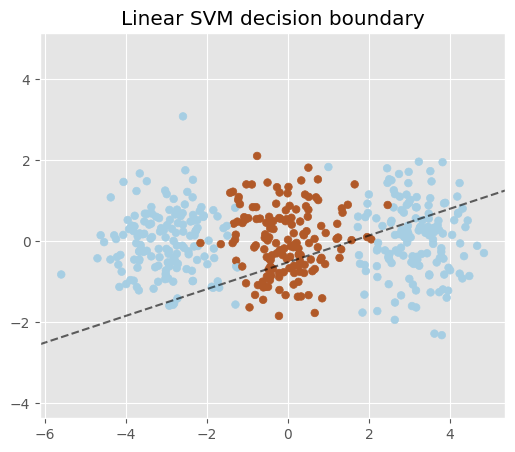

In [ ]:
# Train linear SVM
lin_clf = SVC(kernel="linear", C=1.0)
lin_clf.fit(X_train, y_train)

print(f"Linear SVM | Train/Test: {lin_clf.score(X_train,y_train):.3f}/{lin_clf.score(X_test,y_test):.3f}")

# Plot decision boundary
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Paired, s=30)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 300)
yy = np.linspace(ylim[0], ylim[1], 300)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = lin_clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1,0,1], alpha=0.6, linestyles=['--','-','--'])
plt.title("Linear SVM decision boundary")
plt.axis("equal")
plt.show()

In [ ]:
# SVM RBF + GridSearchCV (C, gamma)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": np.logspace(-2, 3, 8),       
    "gamma": np.logspace(-2, 2, 8)     
}

rbf = SVC(kernel="rbf")

grid = GridSearchCV(
    rbf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)
rbf_clf = grid.best_estimator_

print("Best params (RBF):", grid.best_params_)
print("Best CV accuracy:", np.round(grid.best_score_, 3))
print(f"RBF SVM | Train/Test: {rbf_clf.score(X_train,y_train):.3f}/{rbf_clf.score(X_test,y_test):.3f}")

Best params (RBF): {'C': np.float64(7.196856730011521), 'gamma': np.float64(0.517947467923121)}
Best CV accuracy: 0.973
RBF SVM | Train/Test: 0.976/0.947


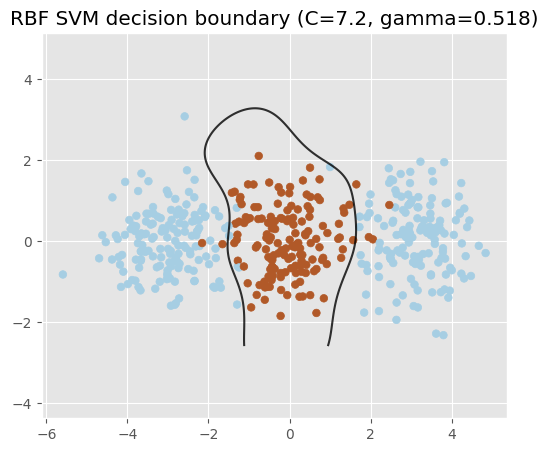

In [ ]:
# Plot frontfrontier RBF 
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=plt.cm.Paired, s=30)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 400)
yy = np.linspace(ylim[0], ylim[1], 400)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = rbf_clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.8, linestyles=['-'])
plt.title(f"RBF SVM decision boundary (C={grid.best_params_['C']:.3g}, gamma={grid.best_params_['gamma']:.3g})")
plt.axis("equal")
plt.show()

## Learning curve

**8)** Draw the learning curve of the algorithm : with fixed hyper-parameters and a fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). For each size, repeat the experiment a large number of times to average the performance. 
Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

Estimated Bayes accuracy (MC): 0.959


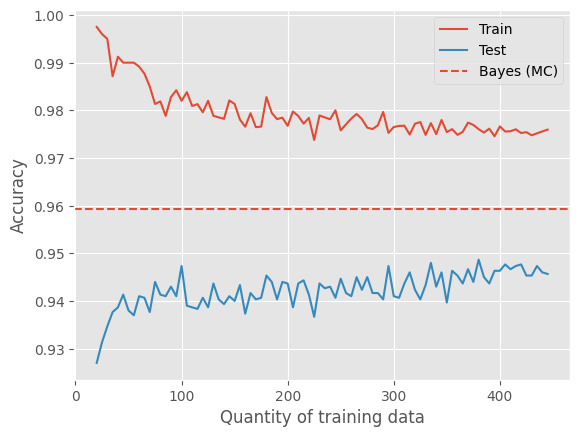

In [ ]:
# Fixed hyperparameters th best from Q7

C_fixed = 7.2
gamma_fixed = 0.518

# Bayes accuracy (Monte Carlo) for the Q6 generator
# Class 1: N(mu1, Sigma)
# Class 0: 0.5 N(mu0L, Sigma) + 0.5 N(mu0R, Sigma)
# Priors: P(y=0)=2/3, P(y=1)=1/3 (since we used 200/200/200 blobs)
mu0L = np.array([-3.0, 0.0])
mu1  = np.array([ 0.0, 0.0])
mu0R = np.array([ 3.0, 0.0])
std = 0.8
Sigma = (std**2) * np.eye(2)

pi0, pi1 = 2/3, 1/3

n_mc = 200000
bayes_correct = 0

for _ in range(n_mc):
    # sample y according to priors
    if np.random.rand() < pi0:
        y_true = 0
        # sample from the mixture components of class 0
        if np.random.rand() < 0.5:
            x = np.random.multivariate_normal(mu0L, Sigma)
        else:
            x = np.random.multivariate_normal(mu0R, Sigma)
    else:
        y_true = 1
        x = np.random.multivariate_normal(mu1, Sigma)

    # class-conditional densities
    p_x_given_1 = multivariate_normal.pdf(x, mean=mu1, cov=Sigma)
    p_x_given_0 = 0.5 * multivariate_normal.pdf(x, mean=mu0L, cov=Sigma) \
                + 0.5 * multivariate_normal.pdf(x, mean=mu0R, cov=Sigma)

    # Bayes decision: argmax_y pi_y * p(x|y)
    y_pred = 1 if (pi1 * p_x_given_1) > (pi0 * p_x_given_0) else 0
    bayes_correct += (y_pred == y_true)

bayes_acc = bayes_correct / n_mc
print(f"Estimated Bayes accuracy (MC): {bayes_acc:.3f}")

# Learning curve
n_tr = len(X_train)

sizes = np.arange(20, n_tr, 5)
n_m = 20

scores_train = []
scores_test = []

for size in sizes:
    score_train = 0.0
    score_test = 0.0

    for i in range(n_m):
        clf = SVC(kernel="rbf", C=C_fixed, gamma=gamma_fixed)

        idx = np.random.choice(n_tr, size=size, replace=False)
        X_train_reduced = X_train[idx, :]
        y_train_reduced = y_train[idx]

        clf.fit(X_train_reduced, y_train_reduced)

        score_train += clf.score(X_train_reduced, y_train_reduced)
        score_test  += clf.score(X_test, y_test)

    scores_train.append(score_train / n_m)
    scores_test.append(score_test / n_m)

# Plot
plt.plot(sizes, scores_train, label='Train')
plt.plot(sizes, scores_test, label='Test')
plt.axhline(bayes_acc, linestyle='--', label='Bayes (MC)')

plt.xlabel('Quantity of training data')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

As the size of the training set increases, the training accuracy slightly decreases while the test accuracy increases and stabilizes, illustrating the reduction of overfitting and the bias–variance trade-off. Both curves progressively approach the Bayes accuracy, which represents the optimal achievable performance given the data-generating distribution.

## Error versus complexity

**9)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.

<div class='alert alert-block alert-info'>
            Code:</div>

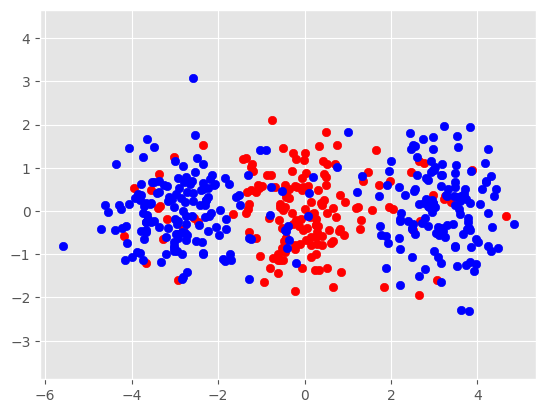

In [50]:
# Modify the class of some data points randomly
n_noise = 50
n_tr = len(y_train)
idx = np.random.choice(range(n_tr), n_noise)
y_train[idx] = 1 - y_train[idx]

pos = np.where(y_train == 1)[0]
neg = np.where(y_train == 0)[0]

# Visualise the data
plt.scatter(X_train[pos,0], X_train[pos,1], c='r')
plt.scatter(X_train[neg,0], X_train[neg,1], c='b')
plt.axis('equal')
plt.show()

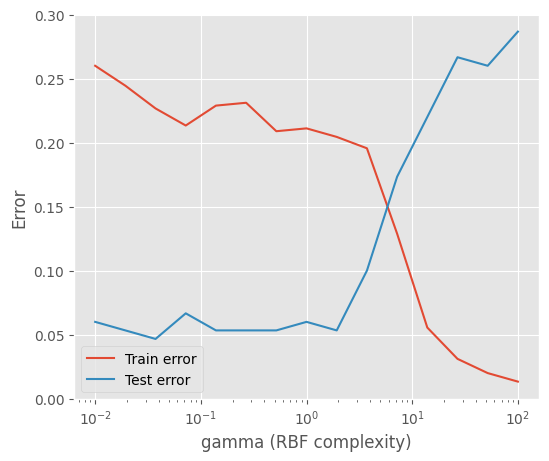

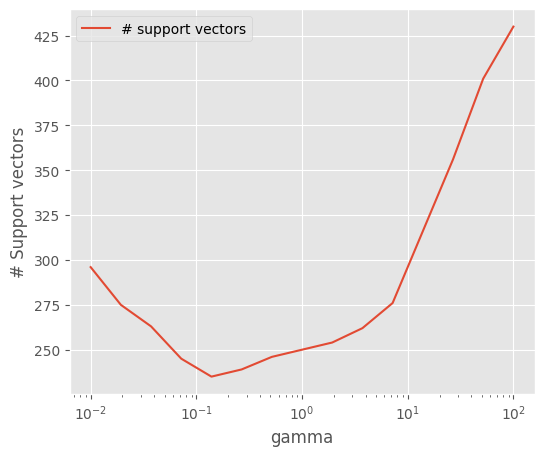

In [ ]:
# Vary the appropriate parameter and plot the training/testing results
y_train_noisy = y_train.copy()

n_noise = 50
n_tr = len(y_train_noisy)
idx = np.random.choice(range(n_tr), n_noise, replace=False)
y_train_noisy[idx] = 1 - y_train_noisy[idx]

# Complexity sweep: vary gamma for RBF 
gammas = np.logspace(-2, 2, 15)  
C_fixed = 7.2  # keep fixed from Q7

train_errors = []
test_errors = []
n_support = []

for gamma in gammas:
    clf = SVC(kernel="rbf", C=C_fixed, gamma=gamma)
    clf.fit(X_train, y_train_noisy)

    train_acc = clf.score(X_train, y_train_noisy) 
    test_acc  = clf.score(X_test, y_test)         

    train_errors.append(1 - train_acc)
    test_errors.append(1 - test_acc)
    n_support.append(clf.support_vectors_.shape[0])

# Plot error vs gamma 
plt.figure(figsize=(6,5))
plt.semilogx(gammas, train_errors, label="Train error")
plt.semilogx(gammas, test_errors, label="Test error")
plt.xlabel("gamma (RBF complexity)")
plt.ylabel("Error")
plt.legend()
plt.show()

# Plot #support vectors vs gamma 
plt.figure(figsize=(6,5))
plt.semilogx(gammas, n_support, label="# support vectors")
plt.xlabel("gamma")
plt.ylabel("# Support vectors")
plt.legend()
plt.show()

Adding label noise makes the classification problem intrinsically inconsistent. As the complexity of the RBF SVM increases, the training error decreases and eventually vanishes, indicating that the model is able to fit even mislabeled points. However, the test error exhibits a U-shaped behavior, with a minimum at intermediate values of the kernel parameter γ. Beyond this point, increasing model complexity leads to overfitting the noise, resulting in poorer generalization. The evolution of the number of support vectors further illustrates this effect, as overly complex models require many support vectors to accommodate noisy constraints.

## Bonus 1 : Application to face classification

Code for downloading and organizing the data:

In [52]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int64)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**10)** By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of $C$ on a logarithmic scale between $1e5$ and $1e-5$.

Fitting linear SVM for different values of C


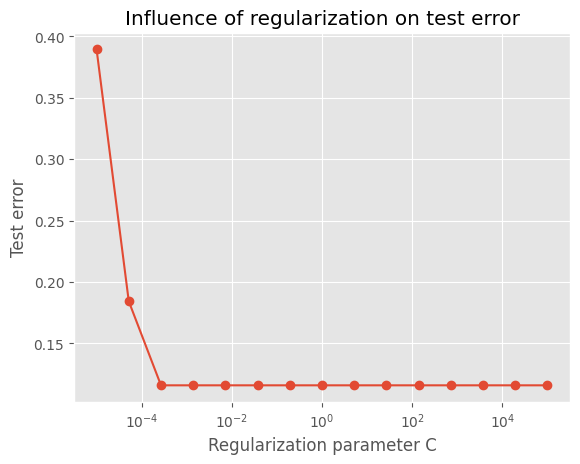

In [ ]:
Cs = np.logspace(-5, 5, 15)
errors = []

print("Fitting linear SVM for different values of C")

for C in Cs:
    clf = svm.SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    error = 1 - clf.score(X_test, y_test)
    errors.append(error)

plt.semilogx(Cs, errors, marker='o')
plt.xlabel("Regularization parameter C")
plt.ylabel("Test error")
plt.title("Influence of regularization on test error")
plt.show()

We observe a strong improvement in test performance as C increases from very small values, corresponding to the model exiting the underfitting regime.
Beyond a certain threshold, the test error stabilizes, indicating that the model has reached its effective capacity without any visible overfitting.

In [ ]:
best_C = Cs[np.argmin(errors)]
clf = svm.SVC(kernel="linear", C=best_C)
clf.fit(X_train, y_train)
print("Best C used for prediction:", best_C)
print("Accuracy with best C:", clf.score(X_test, y_test))

Best C used for prediction: 0.0071968567300115215
Accuracy with best C: 0.8842105263157894


In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images with the best regularization parameter obtained
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.169s
Chance level : 0.6210526315789474
Accuracy : 0.8842105263157894


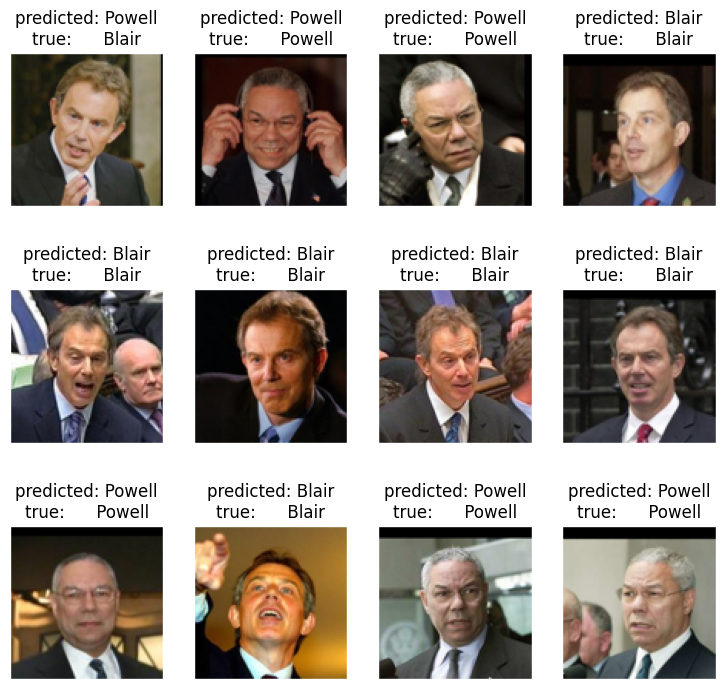

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

# This will just show some examples with their associated prediction 
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

The qualitative gallery is consistent with the quantitative accuracy: most test faces are correctly classified, and the few visible mistakes correspond to ambiguous images (pose/lighting/expression), which are expected even for a well-performing linear SVM.

**11)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

<div class='alert alert-block alert-info'>
        

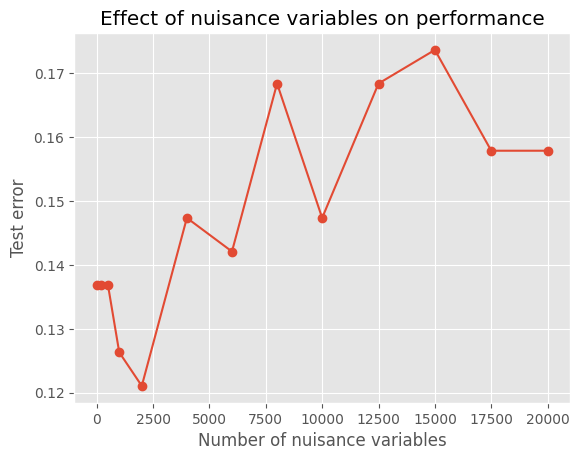

In [64]:
# Add a number of nuisance variable to the existing data points, by generating randomly their values
n_features_list = [0, 200, 500, 1000, 2000, 4000, 6000, 8000, 10000, 12500, 15000, 17500, 20000]
errors = []

for n_noise in n_features_list:
    X_train_noisy = np.hstack([X_train, np.random.randn(X_train.shape[0], n_noise)])
    X_test_noisy  = np.hstack([X_test,  np.random.randn(X_test.shape[0],  n_noise)])

    clf = LinearSVC(C=1.0, max_iter=5000)
    clf.fit(X_train_noisy, y_train)

    error = 1 - clf.score(X_test_noisy, y_test)
    errors.append(error)

plt.plot(n_features_list, errors, marker='o')
plt.xlabel("Number of nuisance variables")
plt.ylabel("Test error")
plt.title("Effect of nuisance variables on performance")
plt.show()

**12)** What is the effect of choosing a non-linear RBF kernel on prediction ? You will be able to improve the prediction with a reduction of dimension based on the object ```sklearn.decomposition.RandomizedPCA```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# Apply the SVM with the chosen kernel after dimension reduction by PCA
pca = PCA(n_components=150, random_state=0, svd_solver="randomized")
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

param_grid = {
    "C": np.logspace(-1, 2, 6),       
    "gamma": np.logspace(-4, -1, 6)    
}

grid = GridSearchCV(SVC(kernel="rbf"), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_pca, y_train)

print("Best params:", grid.best_params_)
print("CV:", grid.best_score_)
print("Train:", grid.best_estimator_.score(X_train_pca, y_train))
print("Test :", grid.best_estimator_.score(X_test_pca, y_test))

clf_raw = SVC(kernel="rbf", C=10, gamma=0.001)
clf_raw.fit(X_train, y_train)

print("(Without PCA:)", clf_raw.score(X_test, y_test))

Best params: {'C': np.float64(6.30957344480193), 'gamma': np.float64(0.0001)}
CV: 0.8736842105263157
Train: 1.0
Test : 0.8736842105263158
(Without PCA:) 0.6105263157894737


Using an RBF kernel directly on raw pixel space performs poorly in high dimension. After RandomizedPCA, the data lie in a lower-dimensional subspace that captures the main facial variations, making distances more meaningful and drastically improving generalization. This illustrates both the curse of dimensionality and the importance of dimensionality reduction before nonlinear kernels.

## Bonus 2 : Optimization

**a)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

The standard soft-margin SVM can be written in its constrained form, with slack variables $\xi_i$, as:

$$\min_{w, w_0, \xi \geq 0} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n \xi_i$$

subject to

$$y_i(\langle w, \Phi(x_i) \rangle + w_0) \geq 1 - \xi_i, \quad \forall i.$$

For fixed $w$ and $w_0$, the constraints impose

$$\xi_i \geq 1 - y_i(\langle w, \Phi(x_i) \rangle + w_0) \quad \text{and} \quad \xi_i \geq 0.$$

Therefore, the smallest admissible value of $\xi_i$ is exactly

$$\xi_i^* = \max(0, 1 - y_i(\langle w, \Phi(x_i) \rangle + w_0)) = [1 - y_i f(x_i)]_+,$$

where

$$f(x) = \langle w, \Phi(x) \rangle + w_0.$$

By substituting $\xi_i$ with $\xi_i^*$ in the objective function, we obtain the unconstrained problem:

$$\min_{w \in H, w_0 \in \mathbb{R}} \frac{1}{2}\|w\|^2 + C\sum_{i=1}^n [1 - y_i(\langle w, \Phi(x_i) \rangle + w_0)]_+,$$

which is exactly the required formulation.

**Quick interpretation:**

- $\frac{1}{2}\|w\|^2$: regularization term (controls model complexity / enforces a large margin)
- The hinge loss penalizes misclassified points and those that are correctly classified but lie too close to the margin.


**b)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

## 1) The classification error (0–1 loss) is non-convex

The "true" loss for binary classification is the 0–1 loss:

$$\ell_{0/1}(y, f(x)) = \mathbb{1}\{yf(x) \leq 0\}$$

It takes value 1 if the point is misclassified, and 0 otherwise.

**Problem:** this loss is discontinuous and non-convex, which makes optimization difficult (NP-hard in general).

## 2) The hinge loss is a convex upper bound of the 0–1 loss

The hinge loss is defined as:

$$\ell_{\text{hinge}}(y, f(x)) = [1 - yf(x)]_+ = \max(0, 1 - yf(x))$$

**Key property:**

- If $yf(x) \leq 0$ (misclassification), then $1 - yf(x) \geq 1$, so the hinge loss is $\geq 1$: it penalizes at least as much as the 0–1 loss.

- If $0 < yf(x) < 1$ (correct classification but inside the margin), the hinge loss is $> 0$: there is still a penalty.

- If $yf(x) \geq 1$ (correct classification with margin), the hinge loss is $0$.

Therefore,

$$\ell_{0/1}(y, f(x)) \leq \ell_{\text{hinge}}(y, f(x)), \quad \forall x$$

and the hinge loss is convex, hence efficiently optimizable.

This is exactly the meaning of the statement: we do not minimize the 0–1 classification error directly; instead, we minimize a **convex upper bound** of it, which makes the problem tractable while remaining aligned with the classification objective.

---

## Difference between hinge loss and 0–1 binary loss

**0–1 loss (pure classification):**

- Only checks the sign ("correct" vs "incorrect").
- A tiny mistake and a very large error are treated the same: loss = 1 in both cases.
- No notion of margin or confidence.

**Hinge loss:**

- Depends on the margin $m = yf(x)$.
- Penalizes:
    - misclassifications ($m \leq 0$),
    - weakly correct classifications ($0 < m < 1$).
- Implicitly rewards solutions that classify correctly with margin ($m \geq 1$).

**In one sentence:**  
The 0–1 loss only measures sign errors, whereas the hinge loss also measures how confident the classification is through the margin, and provides a convex, optimizable approximation of the 0–1 loss.
